### Working with a Document Store - An Exploration of MongoDB's Capabilities 

We will be using the "restaurants.json" dataset provided on Canvas. This notebook serves as an interactive tester for the API, allowing the user to customize parameters, and to visualize set queries.

1. **First, we have to create, connect, and load the data into the database.** This can be done using the command-line with:

`mongoimport --db explore_mongo --collection restaurants --file restaurants.json`

In [ ]:
# Install dependencies.
!pip install pymongo
!pip install matplotlib
!pip install seaborn

In [2]:
# Load the data into the database.
from mongo_db_api import MongoAPI
import json

# Authenticate and initiate connection.
api = MongoAPI()
with open('restaurants.json', 'r') as file:
    # Read the file line by line.
    for line in file:
        # Convert the JSON string to a Python dictionary.
        data = json.loads(line)
        # Insert the data into the database.
        api.insert_one(data)

2. **Exploring the Mongo Query Language**

This dataset exhibits a hirearchical structure with nesting. Some of the general attributes include: 
- Address: Capturing location details such as building number, street, and zipcode.
- Borough: Identifying the borough (district) within New York City.
- Cuisine: Specifying the type of cuisine offered by each restaurant.
- Grades: Representing health inspection grades over time, including attributes like date and score.
- Name: Providing the name of each restaurant.

Many of these fields contain their own dictionaries with more attributes!

Here are some questions we can try to answer about the data, feel free to adjust parameters to delve deeper into the dataset. *These will say "Change this!" next to them.*


In [3]:
# 1. How many restaurants are in a certain borough? (Ex: Brooklyn, Staten Island, Queens)
borough = "Staten Island" # Change this!
print(f"The number of restaurants in {borough} is {api.get_num_restaurants_in_borough(borough)}")

The number of restaurants in Staten Island is 969


In [4]:
# 2. What are the zip codes with the most restaurants?
limit = 5 # Change this!
api.get_zipcodes_most_restaurants(limit)

[{'_id': '10003', 'restaurant_count': 686},
 {'_id': '10019', 'restaurant_count': 675},
 {'_id': '10036', 'restaurant_count': 611},
 {'_id': '10001', 'restaurant_count': 520},
 {'_id': '10022', 'restaurant_count': 485}]

In [5]:
# 3. For a given cuisine, how many restaurants have a certain grade?
grade = "Z" # Change this!
cuisine = "American" # Change this!
print(f"The number of {cuisine} restaurants with grade {grade} is {api.get_num_restaurants_of_grade(grade, cuisine)}")

The number of American restaurants with grade Z is 262


In [6]:
import matplotlib.pyplot as plt

# 4. What scores correspond to each grade?
grades = ["Z", "A", "B", "C", "P"]
for grade in grades:
    print(api.get_grade_score_range(grade))

{'_id': 'Z', 'min_score': -1, 'max_score': 71}
{'_id': 'A', 'min_score': 0, 'max_score': 27}
{'_id': 'B', 'min_score': -1, 'max_score': 57}
{'_id': 'C', 'min_score': -1, 'max_score': 131}
{'_id': 'P', 'min_score': 0, 'max_score': 43}


In [7]:
# 5. What is the most popular cuisine for each borough?
api.get_most_popular_cuisine_per_borough()

[{'_id': 'Brooklyn', 'most_popular_cuisine': 'American', 'count': 1273},
 {'_id': 'Manhattan', 'most_popular_cuisine': 'American', 'count': 3205},
 {'_id': 'Missing', 'most_popular_cuisine': 'American', 'count': 10},
 {'_id': 'Queens', 'most_popular_cuisine': 'American', 'count': 1040},
 {'_id': 'Staten Island', 'most_popular_cuisine': 'American', 'count': 244},
 {'_id': 'Bronx', 'most_popular_cuisine': 'American', 'count': 411}]

The most popular cuisine for each borough is American. Let's delve a bit further and look at the top cuisines overall.

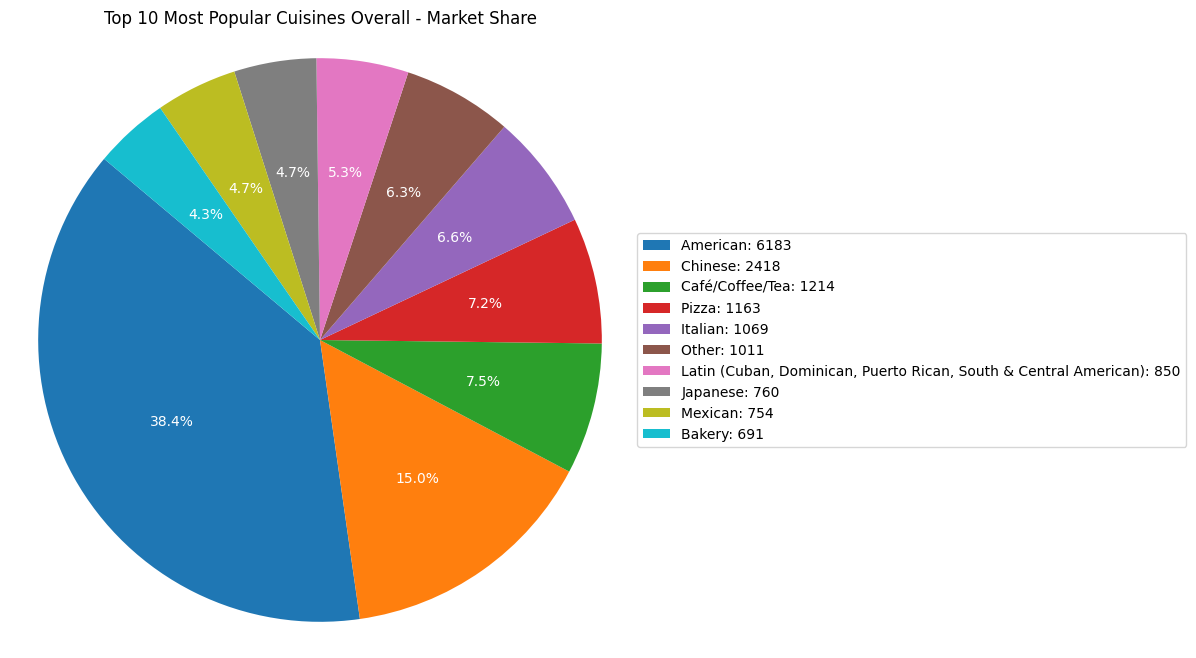

In [8]:
# 6. What are the most popular cuisines overall (by restaurant count)?
limit = 10 # Change this!
most_popular = api.get_most_popular_cuisines_overall(limit)

def circle_plot(most_popular, title_id, limit):
    # Extract cuisines and counts from the data.
    cuisines = []
    counts = []
    for entry in most_popular:
        cuisines.append(entry['_id'])
        counts.append(entry['count'])

    # Plot the data in a pie chart.
    plt.figure(figsize=(8, 8))
    patches, _, autotexts = plt.pie(counts, startangle=140, autopct='%1.1f%%')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title(f'Top {limit} Most Popular Cuisines {title_id} - Market Share')

    # Create legend with labels and numbers.
    legend_labels = [f'{cuisine}: {count}' for cuisine, count in zip(cuisines, counts)]
    plt.legend(patches, legend_labels, loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

    # Add counts to each slice.
    for autotext in autotexts:
        autotext.set_color('white')  # Set text color to white for better visibility.
        autotext.set_fontsize(10)  # Set font size for the count.

    plt.show()

circle_plot(most_popular, "Overall", limit)

Overall, the cuisine with the most restaurants is "American", being 38.4% of all documents in the dataset. From the previous question, this metric is reasonable, seeing as the most popular cuisine in each borough was "American". "Chinese" also takes up a considerable size at 15.0%, however, the rest are relatively distributed equally with a small range.

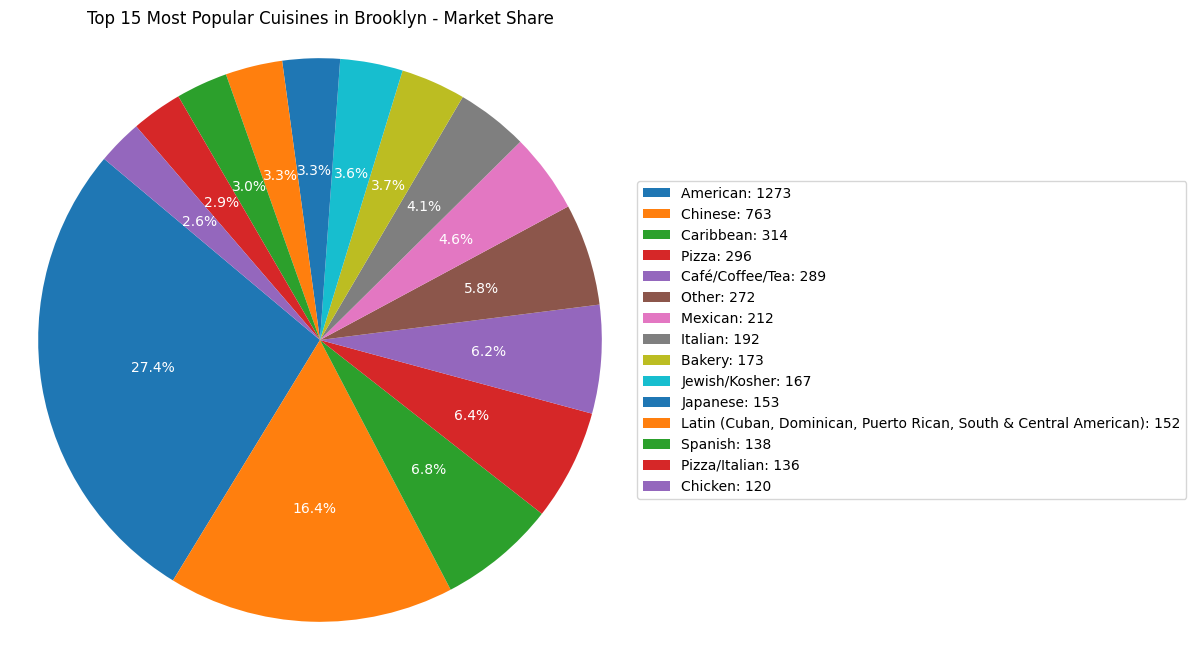

In [9]:
# 7. What are the top cuisines for each borough?
borough = "Brooklyn" # Change this!
limit = 15 # Change this!
most_popular = api.get_top_cuisines_for_borough(borough, limit)

circle_plot(most_popular, f"in {borough}", limit)

We see similar trends in the cuisine popularity distribution when comparing overall popularity to ranking in each borough. "American" and "Chinese" lead, however the difference between these varies significantly, from values of 41.2% and 8.7% in Manhattan to 20.5% and 16.1% in the Bronx respectively.

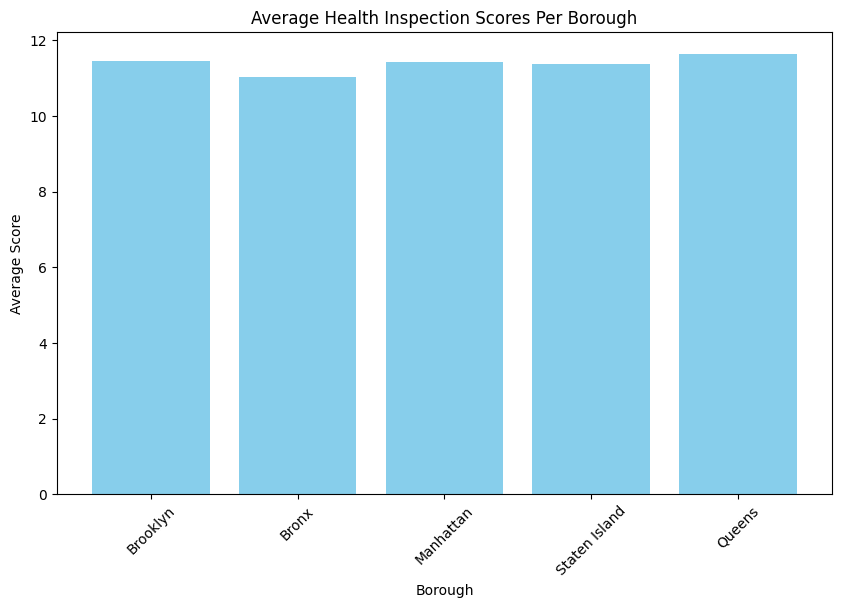

In [10]:
# 8. What are the average health inspections scores for each borough?
avg_scores = api.get_average_scores_per_borough()

# Remove the entry for "Missing" borough label.
data = [entry for entry in avg_scores if entry['_id'] != "Missing"]

# Extract boroughs and average scores.
boroughs = [entry['_id'] for entry in data]
avg_scores = [entry['avg_score'] for entry in data]

# Plot the bar chart.
plt.figure(figsize=(10, 6))
plt.bar(boroughs, avg_scores, color='skyblue')
plt.xlabel('Borough')
plt.ylabel('Average Score')
plt.title('Average Health Inspection Scores Per Borough')
plt.xticks(rotation=45)
plt.show()

It is interesting to see that the average number of health violations remains very similar across all boroughs, hovering around a score of 11. It may be insightful to do some further outlier analysis to see if these averages are being driven by alternate factors.

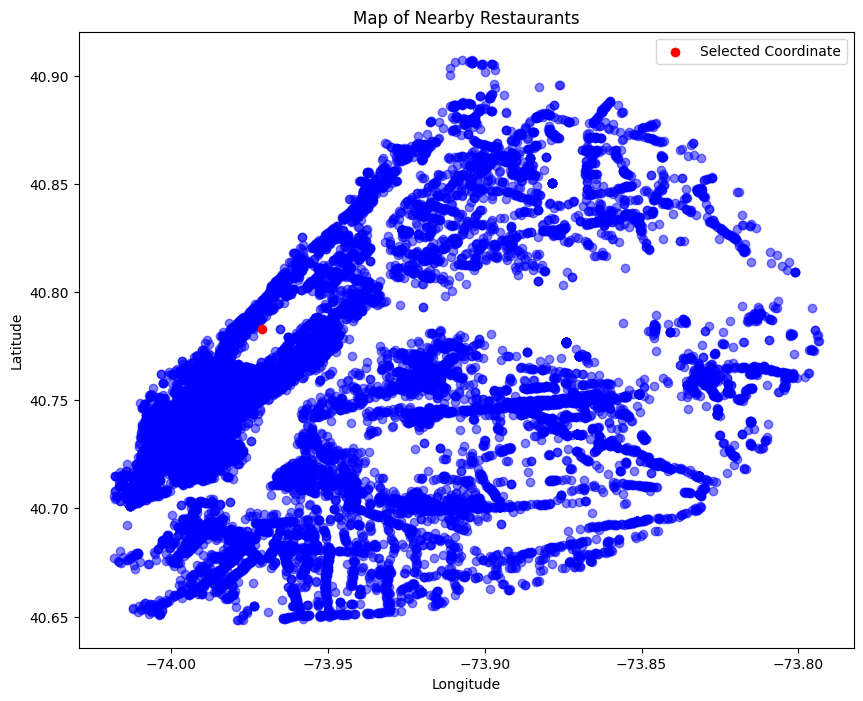

In [11]:
import matplotlib.pyplot as plt

# 9. What restaurants are close to a given coordinate in a certain proximity?
coordinate = (-73.9712, 40.7831) # Change this, ex: central coordinates of Manhattan!"
max_distance_meters = 15000 # Change this!
nearby_restaurants = api.get_nearby_restaurants(coordinate[0], coordinate[1], max_distance_meters)

coordinates = [(restaurant['address']['coord'][1], restaurant['address']['coord'][0]) for restaurant in nearby_restaurants]

# Extract latitude and longitude separately.
latitudes = [coord[0] for coord in coordinates]
longitudes = [coord[1] for coord in coordinates]

# Plot each restaurant as a dot on the map.
plt.figure(figsize=(10, 8))
plt.scatter(longitudes, latitudes, color='blue', alpha=0.5)

# Plot the selected coordinate as a red dot.
plt.scatter(coordinate[0], coordinate[1], color='red', label='Selected Coordinate')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Map of Nearby Restaurants')
plt.legend()
plt.show()

Given the central coordinates of Manhattan, we see that in the distribution of nearby restuarants, not many restaurants show up on the west side. On the west side of Manhattan is a water body which leads to New Jersey, which may explain this. This data set is limited to restaurants present in New York City.

In [12]:
# 10. What are the restaurants of a certain cuisine in each borough?
cuisine = "Bakery" # Change this!
borough = "Queens" # Change this!
api.get_restaurants_of_cuisine(cuisine, borough)

[{'_id': ObjectId('65d54e7daf0a0fb74cbfc31a'),
  'address': {'coord': [-73.90539919999999, 40.7730596]},
  'borough': 'Queens',
  'cuisine': 'Bakery',
  'name': 'Victory Sweet Shop',
  'restaurant_id': '40384920'},
 {'_id': ObjectId('65d54e7daf0a0fb74cbfc32c'),
  'address': {'coord': [-73.91255009999999, 40.7743581]},
  'borough': 'Queens',
  'cuisine': 'Bakery',
  'name': 'Lefkos Pygos Cafe',
  'restaurant_id': '40385657'},
 {'_id': ObjectId('65d54e7daf0a0fb74cbfc3d9'),
  'address': {'coord': [-73.8894548, 40.7470518]},
  'borough': 'Queens',
  'cuisine': 'Bakery',
  'name': 'Miracali Bakery',
  'restaurant_id': '40390973'},
 {'_id': ObjectId('65d54e7daf0a0fb74cbfc3e7'),
  'address': {'coord': [-73.813673, 40.691014]},
  'borough': 'Queens',
  'cuisine': 'Bakery',
  'name': "Sybil'S Bakery",
  'restaurant_id': '40391259'},
 {'_id': ObjectId('65d54e7daf0a0fb74cbfc3e8'),
  'address': {'coord': [-73.7308948, 40.760634]},
  'borough': 'Queens',
  'cuisine': 'Bakery',
  'name': "Richer'S B

Let's try this for all the boroughs and visualize them. Some outliers needed to be removed as they would skew the whole graph window.

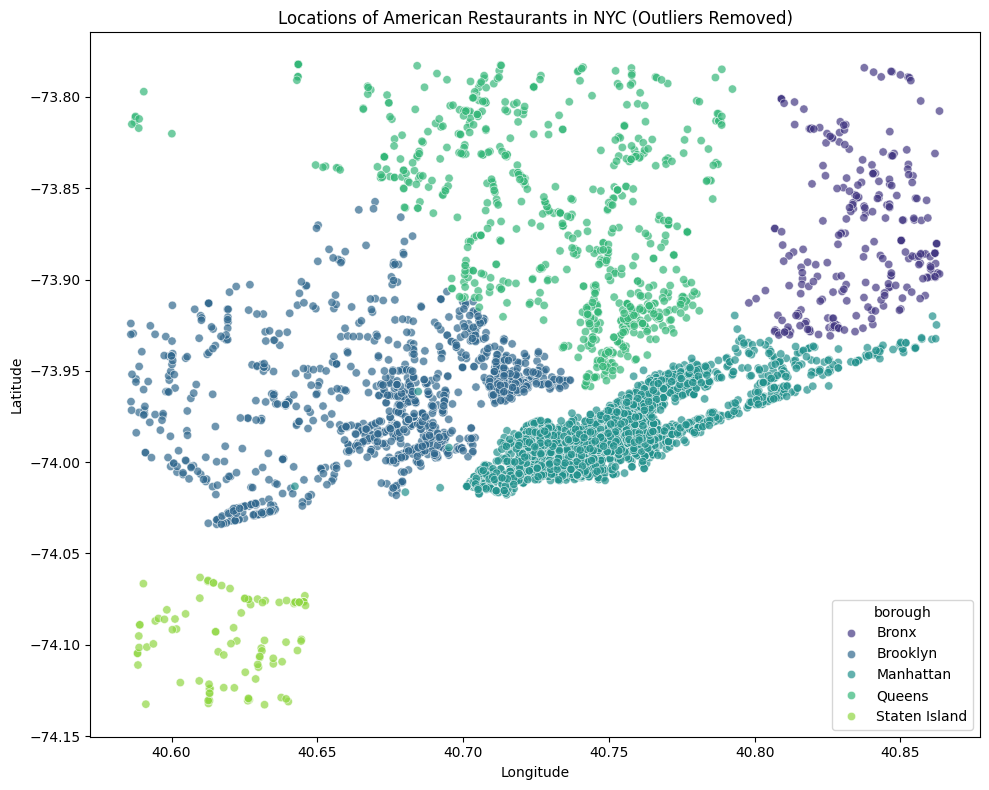

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

cuisine = "American" # Change this!
boroughs = ["Bronx", "Brooklyn", "Manhattan", "Queens", "Staten Island"]

# Collect restaurants for the specified cuisine in each borough
matching_restaurants = []
for borough in boroughs:
    restaurants_in_borough = api.get_restaurants_of_cuisine(cuisine, borough)
    matching_restaurants.extend(restaurants_in_borough)

# Create a DataFrame from the matching restaurants.
import pandas as pd
df = pd.DataFrame(matching_restaurants)

# Define thresholds for latitude and longitude.
latitude_threshold = (df['address'].str.get('coord').str.get(0).quantile(0.03), df['address'].str.get('coord').str.get(0).quantile(0.97))
longitude_threshold = (df['address'].str.get('coord').str.get(1).quantile(0.03), df['address'].str.get('coord').str.get(1).quantile(0.97))

# Filter out outliers based on latitude and longitude thresholds.
filtered_df = df[(df['address'].str.get('coord').str.get(0) >= latitude_threshold[0]) & (df['address'].str.get('coord').str.get(0) <= latitude_threshold[1]) &
                 (df['address'].str.get('coord').str.get(1) >= longitude_threshold[0]) & (df['address'].str.get('coord').str.get(1) <= longitude_threshold[1])]

# Plot the filtered restaurants on a scatterplot.
plt.figure(figsize=(10, 8))
sns.scatterplot(data=filtered_df, x=filtered_df['address'].str.get('coord').str.get(1), y=filtered_df['address'].str.get('coord').str.get(0), hue='borough', palette='viridis', alpha=0.7)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Locations of {cuisine} Restaurants in NYC (Outliers Removed)')
plt.tight_layout()
plt.show()

We can get a glimpse of the general locations of each of the boroughs, as well as the concentrations of different cuisines in each borough. As seen previously, we can truly see how concentrated "American" restuarants are in Manhattan, which made up 41.2% of all restaurants in the borough.